In [1]:
!pip install scalib
!pip3 install trsfile


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import numpy as np
from scipy import stats
import matplotlib
matplotlib.rcParams.update({'font.size':20})
import matplotlib.pyplot as plt
from tqdm import tqdm
import trsfile
import math
from scalib.metrics import Ttest

In [3]:
def get_corr(traces, H):
    (n, t) = traces.shape # n traces of t samples
    (n_bis, m) = H.shape  # n predictions for each of m candidates
    correlation_values = np.empty((1,t), dtype=np.float32)
    DO = traces - (np.einsum("nt->t", traces, dtype='float64', optimize='optimal') / np.double(n)) # compute O - mean(O)
    DP = H - (np.einsum("nm->m", H, dtype='float64', optimize='optimal') / np.double(n)) # compute P - mean(P)
    numerator = np.einsum("nm,nt->mt", DP, DO, optimize='optimal')
    tmp1 = np.einsum("nm,nm->m", DP, DP, optimize='optimal')
    tmp2 = np.einsum("nt,nt->t", DO, DO, optimize='optimal')
    tmp = np.einsum("m,t->mt", tmp1, tmp2, optimize='optimal')
    denominator = np.sqrt(tmp)
    correlation_values = np.nan_to_num(numerator / denominator, nan=0)
    return correlation_values


def to_s(state_bytes):
    s = [0] * 12
    #print("state_bytes len: " + str(len(state_bytes)))
    #print("state_bytes type: " + str(type(state_bytes)))
    j = 0
    for i in range(12):
        s[i] = state_bytes[j] << 0
        j += 1
        s[i] |= state_bytes[j] << 8
        j += 1
        s[i] |= state_bytes[j] << 16
        j += 1
        s[i] |= state_bytes[j] << 24
        j += 1
    return s

def to_bytes(l): # where l is a list or bytearray or bytes
    return bytes(bytearray(l))

def to_state_bytes(s):
    """
    Converts a list of integers to a bytearray representation.

    Args:
        s (list): A list of integers representing the state.

    Returns:
        bytearray: A bytearray representation of the state.

    """
    state_bytes = bytearray(48)
    j = 0
    for i in range(12):
        state_bytes[j] = (s[i] >> 0) & 0xFF
        j += 1
        state_bytes[j] = (s[i] >> 8) & 0xFF
        j += 1
        state_bytes[j] = (s[i] >> 16) & 0xFF
        j += 1
        state_bytes[j] = (s[i] >> 24) & 0xFF
        j += 1
    return state_bytes

def getBit(state_bytes,x,y,z):
    s = to_s(state_bytes)
    lane = s[x+4*y]
    return (lane >> z)&1

def getColumn(state_bytes,x,z):
    return (getBit(state_bytes,x,0,z),getBit(state_bytes,x,1,z),getBit(state_bytes,x,2,z))


def xoodoo_n_rounds(input_bytes,nr):
    s = to_s(input_bytes)
    round_constants = [
        0x058,
        0x038,
        0x3C0,
        0x0D0,
        0x120,
        0x014,
        0x060,
        0x02C,
        0x380,
        0x0F0,
        0x1A0,
        0x012,
    ]
    if(nr == 0):
        return input_bytes
    for j in range(nr):
        round_constant = round_constants[j]
        e = [0, 0, 0, 0]
        #Theta
        for i in range(4):
            r = s[i] ^ s[i + 4] ^ s[i + 8]
            e[i] = (r >> 18) | (r << 14) & 0xFFFF_FFFF
            r = e[i]
            e[i] ^= (r >> 9) | (r << 23) & 0xFFFF_FFFF
        for i in range(12):
            s[i] ^= e[(i - 1) & 3]
        #Rho_west
        s[7], s[4] = s[4], s[7]
        s[7], s[5] = s[5], s[7]
        s[7], s[6] = s[6], s[7]
        for i in range(4):
            s[i+8] = (s[i+8] >> 21) | (s[i+8] << 11) & 0xFFFF_FFFF
        #iota
        s[0] ^= round_constant
        #chi
        for i in range(4):
            a = s[i]
            b = s[i + 4]
            c = s[i + 8]
            s[i]   = (c & ~b) ^ a
            s[i+4] = (a & ~c) ^ b
            s[i+8] = (b & ~a) ^ c
        #Rho_east
        for i in range(4):
            s[i + 4] = (s[i + 4] >> 31) | (s[i + 4] << 1) & 0xFFFF_FFFF
            s[i + 8] = (s[i + 8] >> 24) | (s[i + 8] << 8) & 0xFFFF_FFFF
        s[8], s[10] = s[10], s[8]
        s[9], s[11] = s[11], s[9]
    output_bytes = to_state_bytes(s)
    return output_bytes

def xoodoo__before_chi(input_bytes,nr=1):
    s = to_s(input_bytes)
    round_constants = [
        0x058,
        0x038,
        0x3C0,
        0x0D0,
        0x120,
        0x014,
        0x060,
        0x02C,
        0x380,
        0x0F0,
        0x1A0,
        0x012,
    ]
    if(nr == 0):
        return input_bytes
    for j in range(nr):
        round_constant = round_constants[j]
        e = [0, 0, 0, 0]
        #Theta
        for i in range(4):
            r = s[i] ^ s[i + 4] ^ s[i + 8]
            e[i] = (r >> 18) | (r << 14) & 0xFFFF_FFFF
            r = e[i]
            e[i] ^= (r >> 9) | (r << 23) & 0xFFFF_FFFF
        for i in range(12):
            s[i] ^= e[(i - 1) & 3]
        #Rho_west
        s[7], s[4] = s[4], s[7]
        s[7], s[5] = s[5], s[7]
        s[7], s[6] = s[6], s[7]
        for i in range(4):
            s[i+8] = (s[i+8] >> 21) | (s[i+8] << 11) & 0xFFFF_FFFF
        #iota
        s[0] ^= round_constant
        #chi
    output_bytes = to_state_bytes(s)
    return output_bytes

def chi_rho_east_column(column):
    a, b, c = column
    new_a = (c & ~b) ^ a
    new_b = (a & ~c) ^ b
    new_c = (b & ~a) ^ c

    # Rho_east
    new_a = (new_a >> 31) | (new_a << 1) & 0xFFFF_FFFF
    new_b = (new_b >> 24) | (new_b << 8) & 0xFFFF_FFFF
    new_c = (new_c >> 24) | (new_c << 8) & 0xFFFF_FFFF

    return (new_a, new_b, new_c)

def chi_column(column):
    a, b, c = column
    new_a = (c & ~b) ^ a
    new_b = (a & ~c) ^ b
    new_c = (b & ~a) ^ c

    # Rho_east
    # new_a = (new_a >> 31) | (new_a << 1) & 0xFFFF_FFFF
    # new_b = (new_b >> 24) | (new_b << 8) & 0xFFFF_FFFF
    # new_c = (new_c >> 24) | (new_c << 8) & 0xFFFF_FFFF

    return (new_a, new_b, new_c)

def chi_rho_east(input_bytes):
    s = to_s(input_bytes)
    for i in range(4):
        a = s[i]
        b = s[i + 4]
        c = s[i + 8]
        s[i]   = (c & ~b) ^ a
        s[i+4] = (a & ~c) ^ b
        s[i+8] = (b & ~a) ^ c
        #Rho_east
    for i in range(4):
        s[i + 4] = (s[i + 4] >> 31) | (s[i + 4] << 1) & 0xFFFF_FFFF
        s[i + 8] = (s[i + 8] >> 24) | (s[i + 8] << 8) & 0xFFFF_FFFF
    s[8], s[10] = s[10], s[8]
    s[9], s[11] = s[11], s[9]

    
    output_bytes = to_state_bytes(s)
    return output_bytes


def hamming_distance(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must be of the same length")
    return sum(el1 != el2 for el1, el2 in zip(list1, list2))

def zero_bytes(n):
    return n * b"\x00"

In [4]:
print("Reading traces from file...", end='')
filename = "XOODYAK.trs"
#Read out traces, nonces, ADs, and key
fileType = filename.split('.')[-1]
if fileType == "trs":
    trs = trsfile.open(filename, mode='r')
else:
    raise ValueError("Please provide trs file, or change the code.")

NUMBER_TRACES = trs.get_header(trsfile.Header.NUMBER_TRACES)
N_traces = 50000
if (N_traces==None or N_traces > NUMBER_TRACES):
    N_traces = NUMBER_TRACES

tracesList = []
nonces = []
keys = []
for i in tqdm(range(N_traces), desc="Reading traceset.."):
    tracesList.append(trs[i].samples)
    nonces.append(trs[i].parameters['nonce'].value)
    keys.append(trs[i].parameters['key'].value)

traces = np.array(tracesList,dtype=np.int16)
N = len(traces)
print("Nr of traces:", N)
print("\nNr samples per trace: ", len(traces[0]))

print("Done")

Reading traces from file...

Reading traceset..: 100%|██████████| 50000/50000 [00:01<00:00, 36016.52it/s]

Nr of traces: 50000

Nr samples per trace:  812
Done


In [5]:
initState = bytearray(48)
initState[32] ^= 0x10
initState[33] ^= 0x01
initState[47] ^= 0x02

In [6]:
H = np.zeros((len(nonces), 2), dtype=np.uint8)
prev = None
for i in range(len(nonces)):
    state = to_bytes(keys[0]) + to_bytes(nonces[i]) + zero_bytes(16)

    result = bytearray(a ^ b for a, b in zip(state, initState))

    before = getColumn(result, 0, 0)

    g = xoodoo_n_rounds(result, 1)

    after = getColumn(g, 0, 0)

    hd = hamming_distance(before, after)

    H[i, 0] = hd
    H[i, 1] = np.random.randint(0, 8)

In [7]:
corr = get_corr(traces, H)

In [8]:
traces_mean = np.mean(traces, axis=0)
traces_mean.shape

(812,)

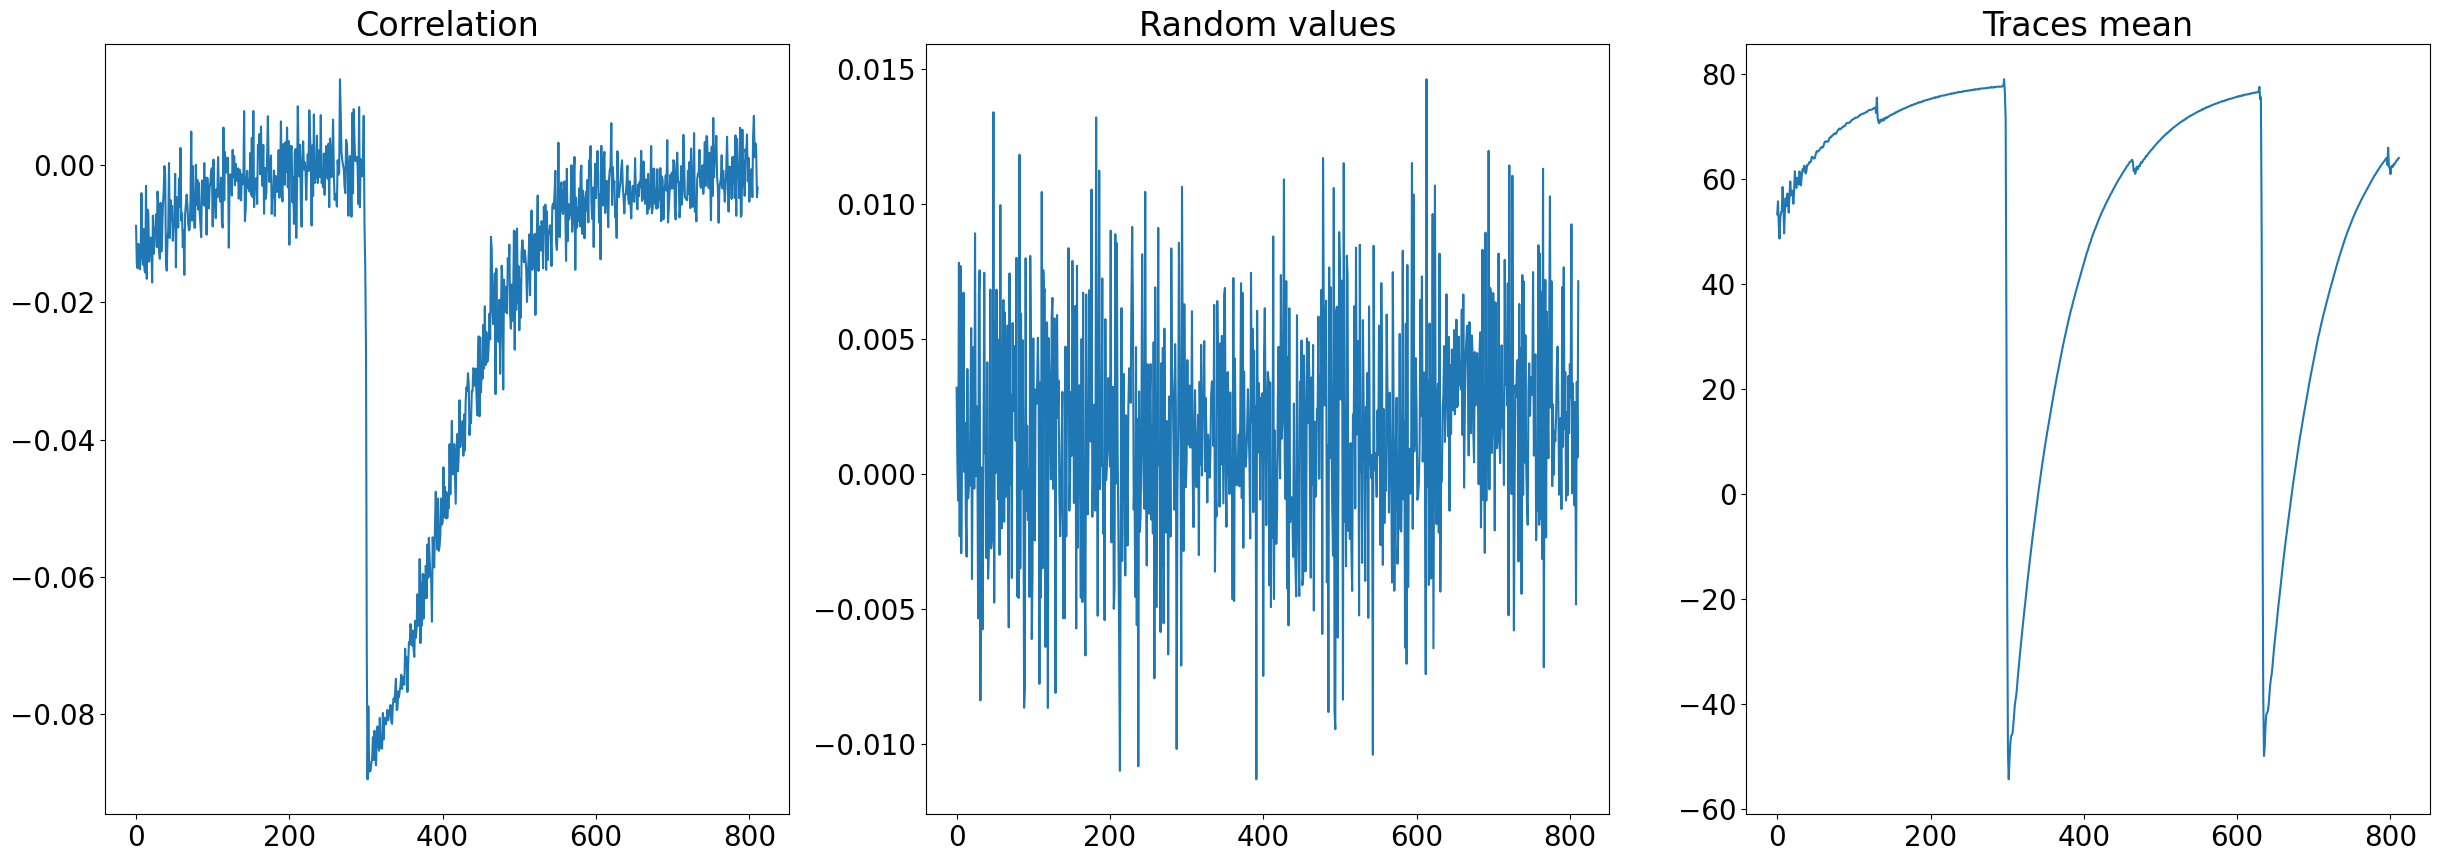

In [9]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.title("Correlation")
plt.plot(corr[0])
plt.subplot(1, 3, 2)
plt.title("Random values")
plt.plot(corr[1])

plt.subplot(1, 3, 3)
plt.title("Traces mean")
plt.plot(traces_mean)
plt.show()

In [24]:
keyInit = to_bytes(keys[0]) + zero_bytes(16) + zero_bytes(16)
# keyInit = bytearray(a ^ b for a, b in zip(keyInit, initState))
keyBeforeChi = xoodoo__before_chi(keyInit, 1)

In [25]:
correct_keys = []
all_guesses = []

for i in range(4):
    for j in range(32):
        col = getColumn(keyBeforeChi, i, j)
        col_init = getColumn(keyInit, i, j)
        correct = list(col)
        correct.append(col_init[0])
        binary = "".join([str(x) for x in correct])
        correct_keys.append(int(binary, 2))
        value_prediction = np.zeros((len(nonces), 16), dtype=int)

        for index, nonce in enumerate(nonces):
            # print(index)
            nonceState = zero_bytes(16) + to_bytes(nonce) + zero_bytes(16)
            nonceState = bytearray(a ^ b for a, b in zip(nonceState, initState))

            nonceBeforeChi = xoodoo__before_chi(nonceState)
            col_nonce = getColumn(nonceBeforeChi, i, j)

            for guess in range(16):
                guess_binary = format(guess, '04b')
                first_three = guess_binary[:3]
                last_one = guess_binary[-1]
                xor = []
                for k in range(3):
                # print(first_five)
                    xor.append(int(first_three[k]) ^ col_nonce[k])
                chi_xor = chi_column(xor)

                before = list(getColumn(nonceState, i, j))
                before[0] = int(last_one)
            # befores.append(before)
                hd = hamming_distance(before, chi_xor)
                value_prediction[index, guess] = hd

                # before = list(getColumn(nonceState, i))
        print(f"Done with column {i}{j}")
        corr = get_corr(traces, value_prediction)
        print(corr.shape)
        max_correlation_index = np.argmax(np.abs(corr))
        max_row, max_col = np.unravel_index(max_correlation_index, corr.shape)
        all_guesses.append(max_row)
        print(f"Row {max_row}, col {max_col}, correlation correct key {correct_keys[-1]}")

Done with column 00
(16, 812)
Row 14, col 310, correlation correct key 14
Done with column 01
(16, 812)
Row 13, col 302, correlation correct key 13
Done with column 02
(16, 812)
Row 14, col 302, correlation correct key 14
Done with column 03
(16, 812)
Row 9, col 302, correlation correct key 1
Done with column 04
(16, 812)
Row 5, col 302, correlation correct key 12
Done with column 05
(16, 812)
Row 0, col 302, correlation correct key 0
Done with column 06
(16, 812)
Row 7, col 302, correlation correct key 15
Done with column 07
(16, 812)
Row 13, col 317, correlation correct key 13
Done with column 08
(16, 812)
Row 6, col 304, correlation correct key 7
Done with column 09
(16, 812)
Row 14, col 308, correlation correct key 14
Done with column 010
(16, 812)
Row 15, col 306, correlation correct key 15
Done with column 011
(16, 812)
Row 10, col 307, correlation correct key 10
Done with column 012
(16, 812)
Row 1, col 308, correlation correct key 8
Done with column 013
(16, 812)
Row 11, col 30

In [26]:
same = np.array(all_guesses) == np.array(correct_keys)
same
print(f"Correctly guessed {np.sum(same)} out of {len(same)}")

Correctly guessed 106 out of 128


In [27]:
# Success rate
np.sum(same) / len(same)

0.828125